## News About Gold

Dataset Source: https://www.kaggle.com/datasets/ankurzing/sentiment-analysis-in-commodity-market-gold

#### Import Necessary Libraries

In [1]:
import os, sys
os.environ['TOKENIZERS_PARALLELISM']='false'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import wandb

import torch

import transformers
from transformers import AutoTokenizer, Trainer, TrainingArguments
from transformers import AutoModelForSequenceClassification, set_seed
from transformers import DataCollatorWithPadding

import datasets
from datasets import Dataset, DatasetDict

import evaluate

!git lfs install

Git LFS initialized.


#### Name Project for Weights & Biases

In [2]:
%env WANDB_PROJECT=News_About_Gold_MPNet-Base
%env WANDB_LOG_MODEL='checkpoint'
%env WANDB_NOTEBOOK_NAME="News About Gold - Sentiment Analysis - MPNet-Base.ipynb"
%env WANDB_WATCH=all

env: WANDB_PROJECT=News_About_Gold_MPNet-Base
env: WANDB_LOG_MODEL='checkpoint'
env: WANDB_NOTEBOOK_NAME="News About Gold - Sentiment Analysis - MPNet-Base.ipynb"
env: WANDB_WATCH=all


#### Log In To Weights & Biases

In [3]:
wandb.login()

wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find "News About Gold - Sentiment Analysis - MPNet-Base.ipynb".
wandb: Currently logged in as: dunnbc22. Use `wandb login --relogin` to force relogin


True

#### Display Library Versions

In [4]:
n = 20

print("Library  ".rjust(15), "Version")
print("*" * (n + 8))

print("Python :".rjust(n), sys.version[0:6])
print("NumPy :".rjust(n), np.__version__)
print("Weights & Biases :".rjust(n), wandb.__version__)
print("Pandas :".rjust(n), pd.__version__)
print("Torch :".rjust(n), torch.__version__)
print("Datasets :".rjust(n), datasets.__version__)
print("Transformers :".rjust(n), transformers.__version__)
print("Evaluate :".rjust(n), evaluate.__version__)

      Library   Version
****************************
            Python : 3.9.12
             NumPy : 1.24.3
  Weights & Biases : 0.15.3
            Pandas : 2.0.1
             Torch : 2.0.0
          Datasets : 2.11.0
      Transformers : 4.28.1
          Evaluate : 0.4.0


#### Ingest Data, Drop Unnecessary Columns, & Rename Remaining Columns

In [5]:
col_names = ["Dates",
             "URL", 
             "text",
             "Price Direction Up",
             "Price Direction Constant",
             "Price Direction Down",
             "Asset Comparision",
             "Past Information",
             "Future Information",
             "label",
             ]

data_types = {"Dates": str,
             "URL": str, 
             "text": str,
             "Price Direction Up": np.uint8,
             "Price Direction Constant": np.uint8,
             "Price Direction Down": np.uint8,
             "Asset Comparision": np.uint8,
             "Past Information": np.uint8,
             "Future Information": np.uint8,
             "label": str
             }

data = pd.read_csv("gold-dataset.csv",
                   names=col_names,
                   dtype=data_types,
                   engine="c",
                   header=0)

data['text'] = data['text'].apply(lambda x: x.strip())

data = data.drop(columns=
                 [
                     'URL',
                     "Price Direction Up",
                     "Price Direction Constant",
                     "Price Direction Down",
                     "Asset Comparision",
                     "Past Information",
                     "Future Information",
                     'Dates'
                    ]
                 )

data

,text,label
0,"april gold down 20 cents to settle at $1,116.1...",negative
1,gold suffers third straight daily decline,negative
2,Gold futures edge up after two-session decline,positive
3,dent research : is gold's day in the sun comin...,none
4,"Gold snaps three-day rally as Trump, lawmakers...",negative
...,...,...
10565,gold seen falling from 3-week high this week,negative
10566,dominic frisby : now looks like a good time to...,positive
10567,Gold heading for worst week since November on ...,negative
10568,august gold up $7.60 at $878.80 an ounce on nymex,positive


#### More Information About Dataset

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10570 entries, 0 to 10569
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    10570 non-null  object
 1   label   10570 non-null  object
dtypes: object(2)
memory usage: 165.3+ KB


#### Title Case All Values in Label

In [7]:
data['label'] = data['label'].apply(lambda x: x.title())

data.head()

,text,label
0,"april gold down 20 cents to settle at $1,116.1...",Negative
1,gold suffers third straight daily decline,Negative
2,Gold futures edge up after two-session decline,Positive
3,dent research : is gold's day in the sun comin...,None
4,"Gold snaps three-day rally as Trump, lawmakers...",Negative


#### Define Function to Create Bar Plot

In [8]:
def barplot_visual(feature_to_visualize: pd.Series,
                   plot_title: str,
                   x_label: str,
                   y_label: str = "# of Samples",
                   rotation: np.int8 = 0,
                   annotation: np.bool_ = True
                   ):
    """
    This function returns a histogram for a feature.
    
    Inputs: 
    - feature_to_visualize: Feature to plot in the form 
    of pandas Series.
    - plot_title: The title of the plot/visual.
    - x_label: The string label value for the x label.
    - y_label: The string label value for the y label.
    - rotation: The integer value of the rotation of 
        x-tick values
    - 
    
    Output:
    - A Bar Plot.
    """
    
    assert type(feature_to_visualize) == pd.Series, \
        "Make sure the dataset input type is a Pandas Series."
    assert type(plot_title) != 'str', \
        "The title value must be a string value."
    assert type(x_label) !=  'str', \
        "The x label value must be a string value."
    assert type(y_label) != 'str', \
        "The y label value must be a string value."
    assert type(rotation) != np.int8, \
        "The rotation value must be an integer value."
    
    ax = feature_to_visualize.value_counts().plot.bar( 
                                                      figsize=(12,8),
                                                      rot=rotation, 
                                                      legend=False,
                                                      color=["lightgreen", 
                                                             "blue", 
                                                             "brown", 
                                                             "lightblue",
                                                             "tan", 
                                                             "yellow", 
                                                             "orange",
                                                             "green", 
                                                             "red",
                                                             "purple"]
                                                      )
    
    if annotation:
        ax.bar_label(ax.containers[0])
    
    plt.suptitle('')
    plt.title(plot_title)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    
    plt.show()

#### Visualization: Distribution of Scores

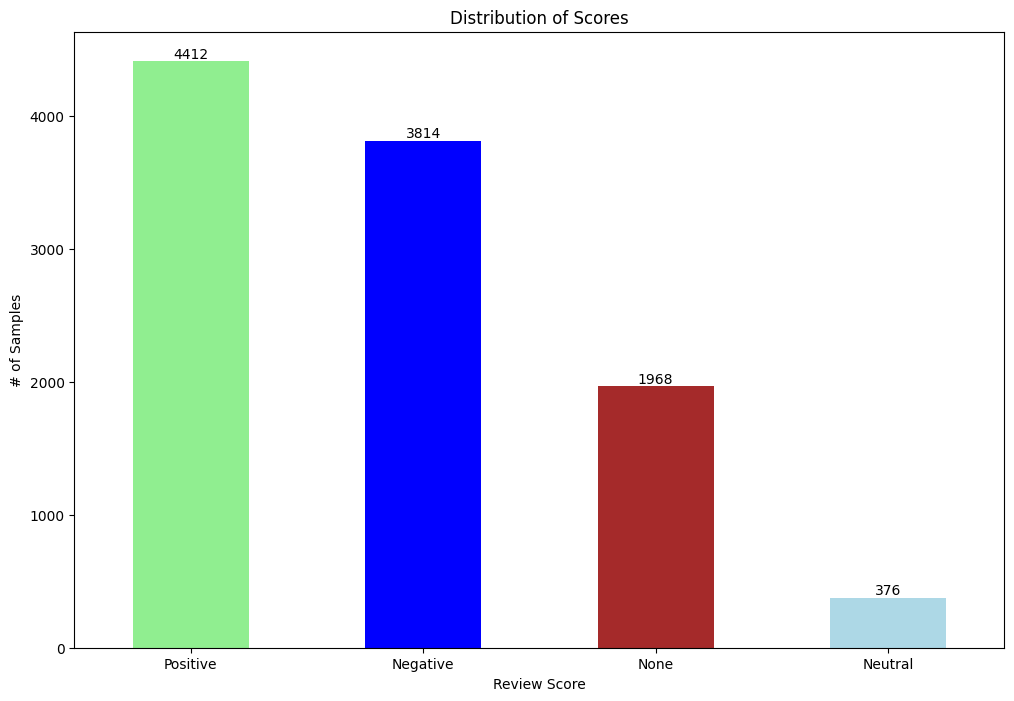

In [9]:
label_distribution = data['label']

barplot_visual(label_distribution,
               "Distribution of Scores",
               "Review Score",
               "# of Samples")

#### Visualization: Distribution of Input Text Length

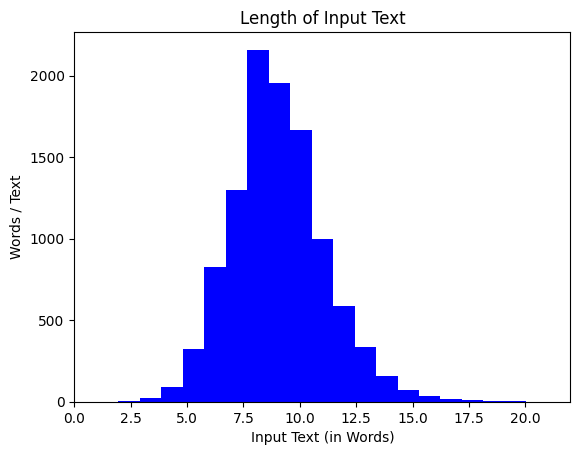

The longest input text is approximately 21 words long.


In [10]:
data['text_length'] = data['text'].str.split().apply(len)

data.hist("text_length", color="Blue", grid=False, bins=21)
plt.title("Length of Input Text")
plt.suptitle('')
plt.xlabel('Input Text (in Words)')
plt.ylabel('Words / Text')
plt.show()

max_len = max(data['text_length'])

print(f"The longest input text is approximately {max_len} words long.")

#### Remove Unnecessary Feature(s)

In [11]:
data = data.drop(columns=['text_length'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10570 entries, 0 to 10569
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    10570 non-null  object
 1   label   10570 non-null  object
dtypes: object(2)
memory usage: 165.3+ KB


#### Create Conversions Between Labels With String & Integer Data Types

In [12]:
UNIQUE_LABEL_VALUES = ['None', 
                       'Negative', 
                       'Neutral', 
                       'Positive']

NUM_LABELS = len(UNIQUE_LABEL_VALUES)

id2label = {idx:label for idx, label in enumerate(UNIQUE_LABEL_VALUES)}
label2id = {label:idx for idx, label in enumerate(UNIQUE_LABEL_VALUES)}

print(UNIQUE_LABEL_VALUES)
print(NUM_LABELS)
print(id2label)
print(label2id)

['None', 'Negative', 'Neutral', 'Positive']
4
{0: 'None', 1: 'Negative', 2: 'Neutral', 3: 'Positive'}
{'None': 0, 'Negative': 1, 'Neutral': 2, 'Positive': 3}


#### Convert Label Values From String to Integer Data Type

In [13]:
data['label'] = data['label'].replace(label2id)

data.head()

,text,label
0,"april gold down 20 cents to settle at $1,116.1...",1
1,gold suffers third straight daily decline,1
2,Gold futures edge up after two-session decline,3
3,dent research : is gold's day in the sun comin...,0
4,"Gold snaps three-day rally as Trump, lawmakers...",1


#### Convert Pandas DataFrame to Datasets

In [14]:
dataset = Dataset.from_pandas(data)

#### Split into Train/Test/Validate Datasets & Combine into DatasetDict

In [15]:
train_eval = dataset.train_test_split(test_size=0.20)

ds = DatasetDict({
    'train' : train_eval['train'],
    'eval' : train_eval['test']
})

print('Training data shape:', ds['train'].shape)
print('Eval data shape:', ds['eval'].shape)

Training data shape: (8456, 2)
Eval data shape: (2114, 2)


#### Determine Longest Tokenized Input Length

In [16]:
MODEL_CKPT = "microsoft/mpnet-base"

tokenizer = AutoTokenizer.from_pretrained(MODEL_CKPT, 
                                             truncation=True, 
                                             padding=True,
                                             batched=True, 
                                             batch_size=None)

tokenized_input_text = [len(tokenizer.encode(a)) for a in ds['train']['text']]

max_tokenized_input_text = max(tokenized_input_text)

print(f"The longest tokenized input text length is approximately {max_tokenized_input_text} tokens.")

The longest tokenized input text length is approximately 39 tokens.


#### Basic Values

In [17]:
NUM_OF_EPOCHS = 5
MAX_INPUT_LENGTH = max_tokenized_input_text

DEVICE = "cpu"
BATCH_SIZE = 64

STRATEGY = "epoch"
MODEL_CKPT = "microsoft/mpnet-base"

MODEL_NAME = f"{MODEL_CKPT.split('/')[-1]}-News_About_Gold"
REPORTS_TO = ["tensorboard", "wandb"]

LR = 2e-5
WANDB_NAME = "News_About_Gold-MPNet_Base"

set_seed(42)

#### Tokenize Whole Dataset

In [18]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_CKPT)

def tokenize(batch):
    return tokenizer(batch['text'], 
                     truncation=True, 
                     padding=True, 
                     max_length=MAX_INPUT_LENGTH, 
                     return_tensors="np")

encoded_ds = ds.map(tokenize, 
                    batched=True, 
                    batch_size=None)

print(encoded_ds['train'].features)
print(encoded_ds['train'])

Map:   0%|          | 0/8456 [00:00<?, ? examples/s]

Map:   0%|          | 0/2114 [00:00<?, ? examples/s]

{'text': Value(dtype='string', id=None), 'label': Value(dtype='int64', id=None), 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}
Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 8456
})


#### Initialize Model

In [19]:
model = (
    AutoModelForSequenceClassification.from_pretrained(MODEL_CKPT, 
                                                       num_labels=NUM_LABELS)
    ).to(DEVICE)

Some weights of the model checkpoint at microsoft/mpnet-base were not used when initializing MPNetForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.decoder.bias', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing MPNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MPNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of MPNetForSequenceClassification were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.bias', 'classifie

#### Define Data Collator

In [20]:
data_collator = DataCollatorWithPadding(tokenizer, 
                                        padding=True)

#### Metrics Evaluation Function

In [21]:
def compute_metrics(p):
    """
    This function takes the predictions output from 
    trainer.evaluate & returns metrics (accuracy, F1, 
    recall, & precision) for a multiclass 
    classification project.
    """
    accuracy_metric = evaluate.load("accuracy")
    accuracy = accuracy_metric.compute(predictions=np.argmax(p.predictions, 
                                                             axis=1), 
                                       references=p.label_ids)['accuracy']
    
    ### ------------------- F1 scores -------------------
    
    f1_score_metric = evaluate.load("f1")
    weighted_f1_score = f1_score_metric.compute(predictions=np.argmax(p.predictions, 
                                                                      axis=1), 
                                                references=p.label_ids, 
                                                average='weighted')["f1"]
    
    micro_f1_score = f1_score_metric.compute(predictions=np.argmax(p.predictions, 
                                                                   axis=1), 
                                             references=p.label_ids, 
                                             average='micro')['f1']
    
    macro_f1_score = f1_score_metric.compute(predictions=np.argmax(p.predictions, 
                                                                   axis=1), 
                                             references=p.label_ids, 
                                             average='macro')["f1"]
    
    ### ------------------- recall -------------------
    
    recall_metric = evaluate.load("recall")
    weighted_recall = recall_metric.compute(predictions=np.argmax(p.predictions, 
                                                                  axis=1), 
                                            references=p.label_ids, 
                                            average='weighted')["recall"]
    
    micro_recall = recall_metric.compute(predictions=np.argmax(p.predictions, 
                                                               axis=1), 
                                         references=p.label_ids, 
                                         average='micro')["recall"]
    
    macro_recall = recall_metric.compute(predictions=np.argmax(p.predictions, 
                                                               axis=1), 
                                         references=p.label_ids, 
                                         average='macro')["recall"]
    
    ### ------------------- precision -------------------
    
    precision_metric = evaluate.load("precision")
    weighted_precision = precision_metric.compute(predictions=np.argmax(p.predictions, 
                                                                        axis=1), 
                                                  references=p.label_ids, 
                                                  average='weighted')["precision"]
    
    micro_precision = precision_metric.compute(predictions=np.argmax(p.predictions, 
                                                                     axis=1), 
                                               references=p.label_ids, 
                                               average='micro')["precision"]
    
    macro_precision = precision_metric.compute(predictions=np.argmax(p.predictions, 
                                                                     axis=1), 
                                               references=p.label_ids, 
                                               average='macro')["precision"]
    
    return {"accuracy" : accuracy, 
            "Weighted F1" : weighted_f1_score,
            "Micro F1" : micro_f1_score,
            "Macro F1" : macro_f1_score,
            "Weighted Recall" : weighted_recall,
            "Micro Recall" : micro_recall,
            "Macro Recall" : macro_recall,
            "Weighted Precision" : weighted_precision,
            "Micro Precision" : micro_precision,
            "Macro Precision" : macro_precision
            }

#### Trainer Arguments

In [22]:
args = TrainingArguments(output_dir=MODEL_NAME, 
                         num_train_epochs=NUM_OF_EPOCHS, 
                         per_device_train_batch_size=BATCH_SIZE, 
                         per_device_eval_batch_size=BATCH_SIZE, 
                         weight_decay=0.01,
                         learning_rate=LR,
                         evaluation_strategy=STRATEGY,
                         logging_strategy=STRATEGY,
                         logging_first_step=True,
                         save_strategy=STRATEGY, 
                         report_to=REPORTS_TO,
                         run_name=WANDB_NAME,
                         group_by_length=True,
                         hub_private_repo=True,
                         push_to_hub=True
                         )

#### Subclass Trainer to Handle Class Imbalance

In [23]:
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = torch.nn.CrossEntropyLoss(weight=torch.tensor([1.0, 2.0, 3.0, 4.0]))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

#### Build Trainer

In [24]:
trainer = Trainer(model=model, 
                  args=args, 
                  train_dataset=encoded_ds['train'], 
                  eval_dataset=encoded_ds['eval'],
                  tokenizer=tokenizer,
                  data_collator=data_collator,
                  compute_metrics=compute_metrics)

Cloning https://huggingface.co/DunnBC22/mpnet-base-News_About_Gold into local empty directory.


#### Train the Trainer

In [25]:
training_results = trainer.train()

/Users/briandunn/Documents/deep_learning/dl/lib/python3.9/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/665 [00:00<?, ?it/s]

You're using a MPNetTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'loss': 1.3711, 'learning_rate': 1.9969924812030075e-05, 'epoch': 0.01}
{'loss': 0.8316, 'learning_rate': 1.6000000000000003e-05, 'epoch': 1.0}


  0%|          | 0/34 [00:00<?, ?it/s]

/Users/briandunn/Documents/deep_learning/dl/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/briandunn/Documents/deep_learning/dl/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.5145628452301025, 'eval_accuracy': 0.8741721854304636, 'eval_Weighted F1': 0.8603964783111477, 'eval_Micro F1': 0.8741721854304636, 'eval_Macro F1': 0.6541101244678926, 'eval_Weighted Recall': 0.8741721854304636, 'eval_Micro Recall': 0.8741721854304636, 'eval_Macro Recall': 0.6583211627008465, 'eval_Weighted Precision': 0.8487159759942685, 'eval_Micro Precision': 0.8741721854304636, 'eval_Macro Precision': 0.6514983136590513, 'eval_runtime': 92.9359, 'eval_samples_per_second': 22.747, 'eval_steps_per_second': 0.366, 'epoch': 1.0}
{'loss': 0.4675, 'learning_rate': 1.2e-05, 'epoch': 2.0}


  0%|          | 0/34 [00:00<?, ?it/s]

{'eval_loss': 0.38334017992019653, 'eval_accuracy': 0.8897824030274362, 'eval_Weighted F1': 0.8857497992346515, 'eval_Micro F1': 0.8897824030274362, 'eval_Macro F1': 0.7813222457459127, 'eval_Weighted Recall': 0.8897824030274362, 'eval_Micro Recall': 0.8897824030274362, 'eval_Macro Recall': 0.7542250746628558, 'eval_Weighted Precision': 0.8862409167175467, 'eval_Micro Precision': 0.8897824030274362, 'eval_Macro Precision': 0.8298483982859975, 'eval_runtime': 98.2754, 'eval_samples_per_second': 21.511, 'eval_steps_per_second': 0.346, 'epoch': 2.0}
{'loss': 0.3276, 'learning_rate': 8.000000000000001e-06, 'epoch': 3.0}


  0%|          | 0/34 [00:00<?, ?it/s]

{'eval_loss': 0.34639957547187805, 'eval_accuracy': 0.8997161778618732, 'eval_Weighted F1': 0.8985275940583456, 'eval_Micro F1': 0.8997161778618732, 'eval_Macro F1': 0.8302162270863822, 'eval_Weighted Recall': 0.8997161778618732, 'eval_Micro Recall': 0.8997161778618732, 'eval_Macro Recall': 0.8211889608220144, 'eval_Weighted Precision': 0.8983772860669298, 'eval_Micro Precision': 0.8997161778618732, 'eval_Macro Precision': 0.8407617622585422, 'eval_runtime': 150.366, 'eval_samples_per_second': 14.059, 'eval_steps_per_second': 0.226, 'epoch': 3.0}


Adding files tracked by Git LFS: ['.DS_Store']. This may take a bit of time if the files are large.


{'loss': 0.2767, 'learning_rate': 4.000000000000001e-06, 'epoch': 4.0}


  0%|          | 0/34 [00:00<?, ?it/s]

{'eval_loss': 0.3097725212574005, 'eval_accuracy': 0.9101229895931883, 'eval_Weighted F1': 0.9102958634272984, 'eval_Micro F1': 0.9101229895931883, 'eval_Macro F1': 0.8411904825173606, 'eval_Weighted Recall': 0.9101229895931883, 'eval_Micro Recall': 0.9101229895931883, 'eval_Macro Recall': 0.8462158734132148, 'eval_Weighted Precision': 0.9105671253733443, 'eval_Micro Precision': 0.9101229895931883, 'eval_Macro Precision': 0.8367140379939209, 'eval_runtime': 89.1543, 'eval_samples_per_second': 23.712, 'eval_steps_per_second': 0.381, 'epoch': 4.0}
{'loss': 0.2429, 'learning_rate': 0.0, 'epoch': 5.0}


  0%|          | 0/34 [00:00<?, ?it/s]

{'eval_loss': 0.3098289370536804, 'eval_accuracy': 0.9068117313150426, 'eval_Weighted F1': 0.9067718382444718, 'eval_Micro F1': 0.9068117313150426, 'eval_Macro F1': 0.8350939169734637, 'eval_Weighted Recall': 0.9068117313150426, 'eval_Micro Recall': 0.9068117313150426, 'eval_Macro Recall': 0.8405569716758818, 'eval_Weighted Precision': 0.907148309421752, 'eval_Micro Precision': 0.9068117313150426, 'eval_Macro Precision': 0.8309489980771267, 'eval_runtime': 87.7591, 'eval_samples_per_second': 24.089, 'eval_steps_per_second': 0.387, 'epoch': 5.0}
{'train_runtime': 6470.395, 'train_samples_per_second': 6.534, 'train_steps_per_second': 0.103, 'train_loss': 0.43008572123104466, 'epoch': 5.0}


#### Save Model & Metrics

In [26]:
trainer.save_model()
trainer.log_metrics("train", training_results.metrics)
trainer.save_metrics("train", training_results.metrics)
trainer.save_state()

Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 1.00/418M [00:00<?, ?B/s]

Upload file runs/Jun06_10-46-05_Brians-Mac-mini.local/events.out.tfevents.1686066371.Brians-Mac-mini.local.637…

To https://huggingface.co/DunnBC22/mpnet-base-News_About_Gold
   bdc19bf..66ffc47  main -> main

To https://huggingface.co/DunnBC22/mpnet-base-News_About_Gold
   66ffc47..fc52a77  main -> main



***** train metrics *****
  epoch                    =        5.0
  train_loss               =     0.4301
  train_runtime            = 1:47:50.39
  train_samples_per_second =      6.534
  train_steps_per_second   =      0.103


#### Push Model to Hub

In [27]:
trainer.push_to_hub(commit_message="All Dunn!!!")

To https://huggingface.co/DunnBC22/mpnet-base-News_About_Gold
   fc52a77..701e514  main -> main



'https://huggingface.co/DunnBC22/mpnet-base-News_About_Gold/commit/701e51423f2061a265e783f9af6ce9391722e839'

#### Save Metrics to CSV File

In [28]:
api = wandb.Api()

# Specify what run for which to record metrics
run = api.run(f"dunnbc22/News_About_Gold_MPNet-Base/u6njythc")

# save metrics for run to csv file
metrics_dataframe = run.history()
metrics_dataframe.to_csv("metrics.csv")

#### Finish Logging to Weights & Biases

In [29]:
wandb.finish()

eval/Macro F1,▁▆███
eval/Macro Precision,▁████
eval/Macro Recall,▁▅▇██
eval/Micro F1,▁▄▆█▇
eval/Micro Precision,▁▄▆█▇
eval/Micro Recall,▁▄▆█▇
eval/Weighted F1,▁▅▆██
eval/Weighted Precision,▁▅▇██
eval/Weighted Recall,▁▄▆█▇
eval/accuracy,▁▄▆█▇
eval/loss,█▄▂▁▁


### Notes & Other Takeaways From This Project

****
- This project is part of a comparison of multiple transformers using the same dataset.
- The results were middle of the pack.
****

### Citation

- Model Checkpoint

    > https://huggingface.co/microsoft/mpnet-base (This is the best I could find since there was neither a model card or citation listed)